***
# **Recommender System**
***

## Business Understanding

The aim of this project is to develop a recommendation system that can help customers find fashion products they like based on their previous shopping behaviour. The recommendation system will use implicit feedback data, such as purchase history and product ratings, to suggest products that may be of interest to customers.

The recommendation model is built using the Alternating Least Squares (ALS) algorithm by utilising implicit feedback data. Exploratoty Data Analysis process was also conducted to find out the distribution, description, and insight of the data, Laplace Smoothing approach was used to help prevent bias towards products with few high-ranking reviews in the top products ranking process by adding a constant to each category to avoid zero probability.

## Data Understanding

This project utilises the [Amazon](https://amazon-reviews-2023.github.io/) dataset for fashion product categories which includes information on purchase history and product ratings by customers, dataset contains more than 2.5M product reviews in the fashion category from 2002 to 2023 (Downloadable [here](https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Amazon_Fashion.jsonl.gz)).


### Data Description

| Field | Type | Explanation |
| --- | --- | --- |
| rating | float | Rating of the product (from 1.0 to 5.0). |
| title | str | Title of the customer review. |
| text | str | Text body of the customer review. |
| images | list | Images that customers post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively. |
| asin | str | ID of the product. |
| parent_asin | str | Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. |
| user_id | str | ID of the reviewer. |
| timestamp | int | Time of the review (unix time). |
| verified_purchase | bool | Customer purchase verification. |
| helpful_vote | int | Helpful votes of the review. |

### Import Necessary Libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Wrangling

In [ ]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

raw_df = load_jsonl('/content/drive/MyDrive/Data Scientist/Amazon_Fashion.jsonl')
raw_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True


Since the timestamp is in code, we need to convert it to make it easier to read.

In [ ]:
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='ms')
raw_df['timestamp'].sort_values()

,timestamp
2303159,2002-05-07 01:51:28.000
514045,2002-07-23 20:54:50.000
522897,2002-09-10 13:38:24.000
256651,2002-10-05 07:53:31.000
2288568,2002-11-02 12:25:58.000
...,...
2492600,2023-09-07 23:27:34.501
2491862,2023-09-09 05:18:14.602
2489861,2023-09-09 21:06:58.172
2492267,2023-09-10 22:12:32.123


It can be seen that the dataset contains sales from 2002 to 2023, we will only use the last 3 years data, 2020-08-01 to 2023-09-11 (the last date in the data).

In [ ]:
df = raw_df[(raw_df['timestamp'] >= '2020-08-01') & (raw_df['timestamp'] <= '2023-09-11')].reset_index(drop=True)
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
1,3.0,Adult friendly; Not for small kids,Works OK for adults and is not at all kid frie...,[],B089S8MFCQ,B089S8MFCQ,AHTTU2FL6FCNBBAESCJHOHHSSW7A,2020-10-21 18:58:06.690,0,True
2,5.0,Bright and summer,What a cute top! Cam wait to wear in warm weat...,[],B087M39LVV,B087M39LVV,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:38:14.143,0,True
3,5.0,My Kid loves these!,My son is a big Ninjago fan and these are perf...,[],B091GMMYPS,B091GMMYPS,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,2022-02-04 18:48:28.824,0,True
4,2.0,Not what was expected,There are lots of raw edges. Not well made. ...,[],B09DQ5M2BB,B09DQ5M2BB,AHREXOGQPZDA6354MHH4ETSF3MCQ,2021-10-21 04:50:43.960,1,True


Next, select the data that will be used in this project.

In [ ]:
df = df.drop(['title', 'text', 'images', 'parent_asin'], axis=1)
df = df.rename(columns={'asin': 'product_id'})
df.head()

,rating,product_id,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
1,3.0,B089S8MFCQ,AHTTU2FL6FCNBBAESCJHOHHSSW7A,2020-10-21 18:58:06.690,0,True
2,5.0,B087M39LVV,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:38:14.143,0,True
3,5.0,B091GMMYPS,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,2022-02-04 18:48:28.824,0,True
4,2.0,B09DQ5M2BB,AHREXOGQPZDA6354MHH4ETSF3MCQ,2021-10-21 04:50:43.960,1,True


We check for missing value and duplicated data.

In [ ]:
df.isnull().sum()

,0
rating,0
product_id,0
user_id,0
timestamp,0
helpful_vote,0
verified_purchase,0


There are no missing value in the data.

In [ ]:
print('Duplicate Data:', df.duplicated().sum())

Duplicate Data: 6568


There are 6568 duplicate data, we will delete this.

In [ ]:
df.drop_duplicates(inplace=True)
print('Duplicated Data:', df.duplicated().sum())

Duplicated Data: 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 645986 entries, 0 to 652553
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             645986 non-null  float64       
 1   product_id         645986 non-null  object        
 2   user_id            645986 non-null  object        
 3   timestamp          645986 non-null  datetime64[ns]
 4   helpful_vote       645986 non-null  int64         
 5   verified_purchase  645986 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 30.2+ MB


Each column has an appropriate data type.

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
rating,645986.0,NaN,NaN,NaN,3.845845,1.0,3.0,5.0,5.0,5.0,1.523778
product_id,645986,334902,B000GAWSDG,1356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,645986,583876,AGZZXSMMS4WRHHJRBUJZI4FZDHKQ,148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,645986,NaN,NaN,NaN,2021-09-08 00:15:41.369068288,2020-08-01 00:04:40.380000,2021-01-30 03:46:16.180499968,2021-07-19 05:59:24.970499840,2022-03-23 11:23:41.930749952,2023-09-10 22:12:32.123000,NaN
helpful_vote,645986.0,NaN,NaN,NaN,0.38292,0.0,0.0,0.0,0.0,623.0,2.393297
verified_purchase,645986,2,True,584112,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears that there are no anomalies in each column.

## EDA

Let's look at the distribution of rating, verified_purchase, and helpful_vote features in the dataset.

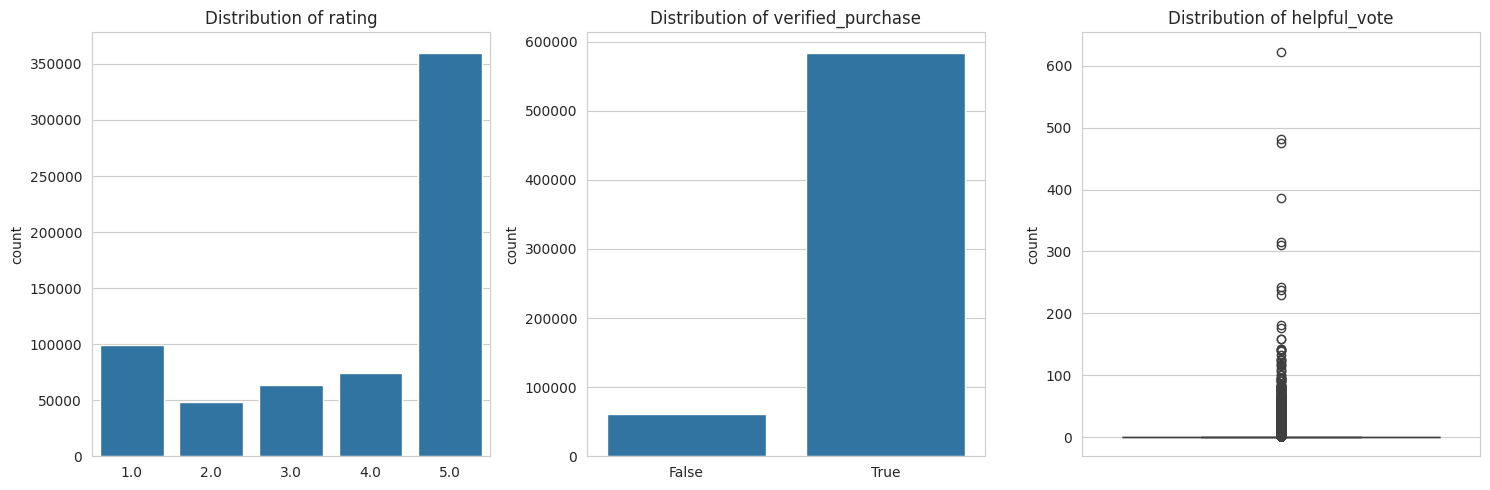

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15,5))
for i, feature in enumerate(['rating', 'verified_purchase']):
    sns.countplot(data=df, x=feature, ax=ax[i])
    ax[i].set_title(f'Distribution of {feature}')
    ax[i].set_xlabel(None)

sns.boxplot(data=df, y='helpful_vote', ax=ax[2])
ax[2].set_title('Distribution of helpful_vote')
ax[2].set_ylabel('count')

plt.tight_layout()
plt.show()

What days and times are customers most active?

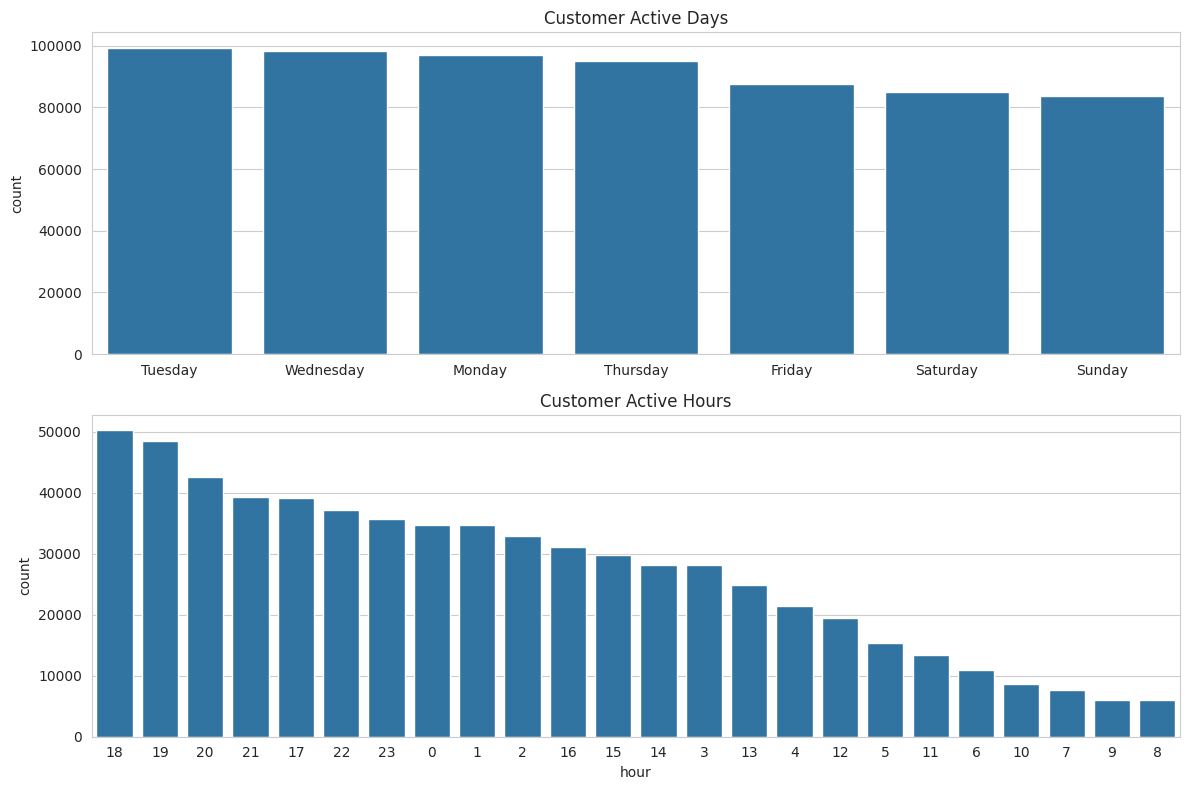

In [ ]:
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=df, x='day_of_week', order=df['day_of_week'].value_counts().index)
plt.title('Customer Active Days')
plt.xlabel(None)

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=df, x='hour', order=df['hour'].value_counts().index)
plt.title('Customer Active Hours')

plt.tight_layout()
plt.show()

Now let's see how many ratings, unique product, and unique customers are in the dataset.

In [ ]:
n_ratings = len(df)
n_customers = df['user_id'].nunique()
n_products = df['product_id'].nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of customers: {n_customers}')
print(f'Number of products: {n_products}')
print(f'Average number of ratings per customer: {round(n_ratings/n_customers, 2)}')
print(f'Average number of ratings per product: {round(n_ratings/n_products, 2)}')

Number of ratings: 645986
Number of customers: 583876
Number of products: 334902
Average number of ratings per customer: 1.11
Average number of ratings per product: 1.93


Let's see who gave the most ratings and distribution of user rating frequency.

In [ ]:
ratings_per_customer = df[['user_id', 'product_id']].groupby('user_id').count().reset_index()
ratings_per_customer.columns = ['user_id', 'n_ratings']
ratings_per_customer.sort_values('n_ratings', ascending=False)

,user_id,n_ratings
437790,AGZZXSMMS4WRHHJRBUJZI4FZDHKQ,148
535380,AHPG65LKS3QKRWDUWAKZNLEK5RZQ,94
535381,AHPG65LKS3QKRWDUWAKZNLEK5RZQ_1,83
494625,AHGIDR4IJFS23Q4GTZ33FI5LYDSQ_1,82
59187,AEGYU6OM2X66SMZN6AF3TSQ3N5PQ,75
...,...,...
201682,AFG7B6HBV72WBBGOKFQ53F63ON5Q,1
201681,AFG7B2DQNI6AFHCQO5EKQKBZGWVA,1
201679,AFG7AME5UI6PDH5YX5PFZ3GPCYTA,1
201678,AFG7AM3LAOFDCTJ6ESH2SPNAKJEQ,1


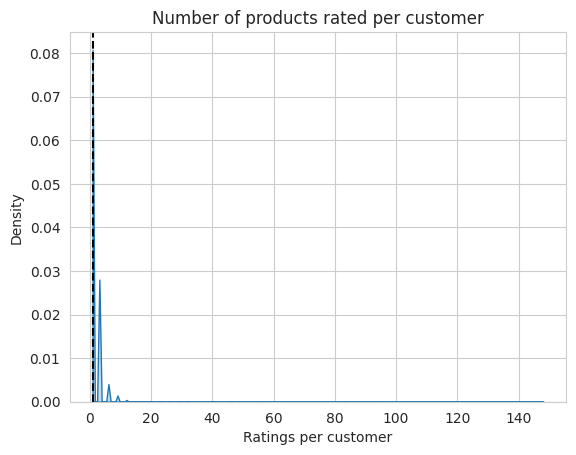

In [ ]:
sns.set_style("whitegrid")
sns.kdeplot(ratings_per_customer['n_ratings'], fill=True, legend=False)
plt.title("Number of products rated per customer")
plt.xlabel("Ratings per customer")
plt.axvline(ratings_per_customer['n_ratings'].mean(), color="k", linestyle="--")
plt.show()

What are the highest and lowest rated product?

In [ ]:
mean_rating = df.groupby('product_id')[['rating']].mean()
mean_rating.head()

,rating
product_id,
0512238944,5.0
0512238987,3.0
0512238995,5.0
0512239045,5.0
0512239134,5.0


In [ ]:
display(df.loc[df['product_id'] == mean_rating['rating'].idxmax()],
        df.loc[df['product_id'] == mean_rating['rating'].idxmin()])

,rating,product_id,user_id,timestamp,helpful_vote,verified_purchase,day_of_week,hour
388743,5.0,0512238944,AFP7ALY4O7FJGR4QDW2F4ZFKHYWA,2022-06-24 18:41:57.692,0,False,Friday,18
496982,5.0,0512238944,AH4YEZV2KLY4ANWX6ULQGQC264NA,2022-05-18 11:54:32.495,0,True,Wednesday,11


,rating,product_id,user_id,timestamp,helpful_vote,verified_purchase,day_of_week,hour
35354,1.0,0610318861,AGUL4PZQIXTCSKV5JIGV45ZPQLVQ,2021-04-03 18:53:18.001,0,True,Saturday,18


Although the product with id '0512238944' is the product with the highest average rating, it only received 2 reviews, which is not a good measure for a top product.

We apply the Laplace Smoothing method, which is a technique that adds a constant to each category to avoid zero probability. To ensure that products with a small number of reviews do not dominate.

$$ \text{Laplace Score} = \frac{\sum R_i + k \cdot R_{\text{avg}}}{n + k} $$

- ∑Ri​: Total number of rating for the product.
- n: Number of product reviews.
- k: Constant (the number of additional reviews we add).
- Ravg​: Global average rating of all product.

In [ ]:
product_ratings = df.groupby('product_id').agg(
    rating_sum=('rating', 'sum'),
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
).reset_index()
product_ratings.head()

,product_id,rating_sum,rating_count,rating_mean
0,0512238944,10.0,2,5.0
1,0512238987,3.0,1,3.0
2,0512238995,10.0,2,5.0
3,0512239045,5.0,1,5.0
4,0512239134,5.0,1,5.0


In [ ]:
def laplace_smoothing(row, global_avg, k):
    return (row['rating_sum'] + k * global_avg) / (row['rating_count'] + k)

global_avg_rating = df['rating'].mean()

product_ratings['laplace_score'] = product_ratings.apply(
    laplace_smoothing, global_avg=global_avg_rating, k=5, axis=1
)

top_products = product_ratings.sort_values('laplace_score', ascending=False)
top_products = top_products.set_index('product_id')
print('Highest Product:\n', top_products.head(10), '\n')
print('Lowest Product:\n', top_products.tail(10))

Highest Product:
             rating_sum  rating_count  rating_mean  laplace_score
product_id                                                      
B0B9144W3P       633.0           128     4.945312       4.903979
B0B93NHYXG      2090.0           427     4.894614       4.882475
B0B93KC657       160.0            32     5.000000       4.844033
B08CDTNQ5G       677.0           139     4.870504       4.834925
B08DNPCWDS       237.0            48     4.937500       4.834514
B0B1B2PM71       140.0            28     5.000000       4.825128
B003WJZDQW       468.0            96     4.875000       4.824052
B088H3VDXX       260.0            53     4.905660       4.814297
B08DQS3QRQ       197.0            40     4.925000       4.805094
B07YB19RRY       197.0            40     4.925000       4.805094 

Lowest Product:
             rating_sum  rating_count  rating_mean  laplace_score
product_id                                                      
B08R79TYXQ        54.0            38     1.421053    

Based on the laplace score result, produk with id '0512238944' (top product before Laplace Smoothing is applied) is not visible in the top product list. The product that has the highest laplace score is the product with product_id 'B0B9144W3P', let's check the product details.

In [ ]:
display(df[df['product_id']=='B0B9144W3P'].rating.value_counts(),
        df[df['product_id']=='B0B9144W3P'])

,count
rating,
5.0,122
4.0,5
3.0,1


,rating,product_id,user_id,timestamp,helpful_vote,verified_purchase,day_of_week,hour
2895,4.0,B0B9144W3P,AEJTVQO2CAMBATXDKI3FHFNA2YXQ,2022-12-11 11:58:42.359,0,True,Sunday,11
14800,5.0,B0B9144W3P,AGYLJX6H7WHB6JXZG43JIASY4GLQ,2022-10-27 12:32:17.033,0,True,Thursday,12
47363,5.0,B0B9144W3P,AHHWLOCRHVWUPVMA7VZRHB25Q5YA,2022-11-11 14:20:56.986,0,True,Friday,14
47531,5.0,B0B9144W3P,AH4Q76PAHTYTJNK4VOEN3L6FIW4A,2022-11-07 15:38:26.904,0,True,Monday,15
56372,5.0,B0B9144W3P,AFIJ6JS2MAUIB3ZSADU7NAWUEFOA,2022-10-25 00:30:42.546,0,True,Tuesday,0
...,...,...,...,...,...,...,...,...
644107,5.0,B0B9144W3P,AEF2T43R6R3WJDUDNBZ3L4LSKCYQ,2022-11-01 15:52:59.274,0,True,Tuesday,15
645057,5.0,B0B9144W3P,AEELDMMAFDFSLBJJBJZLGPLN5MVQ,2022-11-03 13:13:58.386,0,True,Thursday,13
645416,5.0,B0B9144W3P,AEETF62N57H4L4C4H2WAEPCG3IIA,2022-10-25 20:58:46.806,0,True,Tuesday,20
647831,5.0,B0B9144W3P,AG67X4BK34H74TJ7QGP2WKELKAAQ,2022-10-31 16:53:38.837,0,True,Monday,16


It appears that the product has quite good reviews.

## Data Preparation

We select the features that will be used in the model.

In [ ]:
main_df = df[['user_id', 'product_id', 'rating', 'helpful_vote', 'verified_purchase']]
main_df.head()

,user_id,product_id,rating,helpful_vote,verified_purchase
0,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B07B4JXK8D,5.0,0,True
1,AHTTU2FL6FCNBBAESCJHOHHSSW7A,B089S8MFCQ,3.0,0,True
2,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,B087M39LVV,5.0,0,True
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B091GMMYPS,5.0,0,True
4,AHREXOGQPZDA6354MHH4ETSF3MCQ,B09DQ5M2BB,2.0,1,True


Then we normalise the feature rating and helpful_vote to have the same scale.

In [ ]:
main_df['helpful_vote_norm'] = main_df['helpful_vote'] / main_df['helpful_vote'].max()
main_df['rating_norm'] = main_df['rating'] / main_df['rating'].max()
main_df.head()

<ipython-input-96-73d3ace1587e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['helpful_vote_norm'] = main_df['helpful_vote'] / main_df['helpful_vote'].max()
<ipython-input-96-73d3ace1587e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['rating_norm'] = main_df['rating'] / main_df['rating'].max()


,user_id,product_id,rating,helpful_vote,verified_purchase,helpful_vote_norm,rating_norm
0,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B07B4JXK8D,5.0,0,True,0.000000,1.0
1,AHTTU2FL6FCNBBAESCJHOHHSSW7A,B089S8MFCQ,3.0,0,True,0.000000,0.6
2,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,B087M39LVV,5.0,0,True,0.000000,1.0
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B091GMMYPS,5.0,0,True,0.000000,1.0
4,AHREXOGQPZDA6354MHH4ETSF3MCQ,B09DQ5M2BB,2.0,1,True,0.001605,0.4


In [ ]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,645986.0,3.845845,1.523778,1.0,3.0,5.0,5.0,5.0
helpful_vote,645986.0,0.382920,2.393297,0.0,0.0,0.0,0.0,623.0
helpful_vote_norm,645986.0,0.000615,0.003842,0.0,0.0,0.0,0.0,1.0
rating_norm,645986.0,0.769169,0.304756,0.2,0.6,1.0,1.0,1.0


We weight the three features to get the implicit score.

In [ ]:
main_df['implicit_score'] = (
    0.5 * main_df['rating_norm'] +
    0.3 * main_df['helpful_vote_norm'] +
    0.2 * main_df['verified_purchase'].astype(int))
main_df.head()

,user_id,product_id,rating,helpful_vote,verified_purchase,helpful_vote_norm,rating_norm,implicit_score
0,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B07B4JXK8D,5.0,0,True,0.000000,1.0,0.700000
1,AHTTU2FL6FCNBBAESCJHOHHSSW7A,B089S8MFCQ,3.0,0,True,0.000000,0.6,0.500000
2,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,B087M39LVV,5.0,0,True,0.000000,1.0,0.700000
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B091GMMYPS,5.0,0,True,0.000000,1.0,0.700000
4,AHREXOGQPZDA6354MHH4ETSF3MCQ,B09DQ5M2BB,2.0,1,True,0.001605,0.4,0.400482


And then we create a matrix that will be used to train the model with user_id as the row index, product_id as the column index, and implicit score as the value of the matrix.

In [ ]:
from scipy.sparse import csr_matrix

C = main_df['user_id'].nunique()
P = main_df['product_id'].nunique()

customer_mapper = dict(zip(np.unique(main_df['user_id']), list(range(C))))
product_mapper = dict(zip(np.unique(main_df['product_id']), list(range(P))))
customer_inv_mapper = dict(zip(list(range(C)), np.unique(main_df['user_id'])))
product_inv_mapper = dict(zip(list(range(P)), np.unique(main_df['product_id'])))

row_index = [customer_mapper[i] for i in main_df['user_id']]
col_index = [product_mapper[i] for i in main_df['product_id']]

user_item_matrix = csr_matrix((main_df['implicit_score'], (row_index, col_index)), shape=(C, P))
user_item_matrix

In [ ]:
print(user_item_matrix)

  (0, 21254)	0.7
  (1, 226267)	0.3004815409309791
  (2, 325286)	0.5
  (3, 62917)	0.30000000000000004
  (4, 30428)	0.7
  (4, 278561)	0.7
  (5, 143341)	0.7
  (6, 181004)	0.6000000000000001
  (7, 26735)	0.7
  (8, 251766)	0.5009630818619583
  (9, 96212)	0.7
  (10, 256029)	0.7
  (11, 252284)	0.7
  (12, 176098)	0.7
  (13, 52379)	0.30000000000000004
  (14, 167531)	0.7
  (15, 578)	0.7
  (16, 41636)	0.7
  (16, 182339)	0.7004815409309793
  (17, 305342)	0.7
  (18, 128361)	0.7
  (19, 130753)	0.40048154093097915
  (20, 36992)	0.7
  (21, 188715)	0.7
  (22, 179544)	0.4
  :	:
  (583854, 193961)	0.4
  (583854, 227813)	0.7
  (583855, 153153)	0.6000000000000001
  (583856, 223611)	0.6009630818619582
  (583857, 126629)	0.7
  (583858, 267166)	0.6000000000000001
  (583859, 31826)	0.7
  (583860, 204312)	0.7
  (583860, 307491)	0.5028892455858748
  (583861, 79343)	0.7004815409309793
  (583862, 9532)	0.4
  (583863, 181296)	0.7
  (583864, 236879)	0.7
  (583865, 208235)	0.3009630818619583
  (583866, 274695)	0.5
  

## Modeling

Let's train the model with matrix we have created.

In [ ]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50, use_gpu=False)
model.fit(user_item_matrix)

### Top N Recommender

In [ ]:
def get_recommendation(user_id, N=10):
    if user_id in customer_mapper:
        customer_index = customer_mapper[user_id]
        user_items = user_item_matrix[customer_index, :].tocsr()
        recommendations = model.recommend(customer_index, user_items, N=N)
        product_indices, scores = recommendations
        filtered_recommendations = [(product_index, score) for product_index, score in zip(product_indices, scores) if product_index in product_inv_mapper]
    else:
        popular_products = top_products['laplace_score'].index[:10]
        filtered_recommendations = [(product_mapper[product], top_products.loc[f'{product}', 'laplace_score']) for product in popular_products if product in product_mapper]

    print(f"Top {N} Recommendations for UserId {user_id}:")
    for recommendation in filtered_recommendations:
        item_index, score = recommendation[0], recommendation[1]
        product_id = product_inv_mapper.get(item_index, "Unknown")
        print(f'Product ID: {product_id}, Score: {score}')

Let's try to get product recommendations for exiting customer with user_id 'AHTTU2FL6FCNBBAESCJHOHHSSW7A' from the models.

In [ ]:
if 'AHTTU2FL6FCNBBAESCJHOHHSSW7A' in main_df['user_id'].values:
  get_recommendation('AHTTU2FL6FCNBBAESCJHOHHSSW7A')
else:
  print('This is a new customer')

Top 10 Recommendations for UserId AHTTU2FL6FCNBBAESCJHOHHSSW7A:
Product ID: B08H1BB8W4, Score: 8.398727893710323e-12
Product ID: B08FRD28K9, Score: 2.6958249001174384e-12
Product ID: B08CXT5KZL, Score: 8.597213110687896e-13
Product ID: B08C2KKXNP, Score: 8.504503525019746e-13
Product ID: B07XWQ99TZ, Score: 8.417906129098984e-13
Product ID: B0B93NHYXG, Score: 8.215484499293768e-13
Product ID: B07P8QVFBP, Score: 7.099295110113424e-13
Product ID: B07B4JXK8D, Score: 4.246603069191224e-13
Product ID: B09HZMKQ5T, Score: 2.3533551409687936e-13
Product ID: B08DNCT32N, Score: 2.2683775430937247e-13


Now for new customer with user_id 'TZIYHRCLTADI7R5STTUCVRE2CQMU'

In [ ]:
if 'TZIYHRCLTADI7R5STTUCVRE2CQMU' not in main_df['user_id'].values:
  get_recommendation('TZIYHRCLTADI7R5STTUCVRE2CQMU')
else:
  print('This is not a new customer')

Top 10 Recommendations for UserId TZIYHRCLTADI7R5STTUCVRE2CQMU:
Product ID: B0B9144W3P, Score: 4.903979133698956
Product ID: B0B93NHYXG, Score: 4.882475057365651
Product ID: B0B93KC657, Score: 4.844033102215168
Product ID: B08CDTNQ5G, Score: 4.834925172096953
Product ID: B08DNPCWDS, Score: 4.834513675131343
Product ID: B0B1B2PM71, Score: 4.825128023695795
Product ID: B003WJZDQW, Score: 4.8240517305144675
Product ID: B088H3VDXX, Score: 4.814296978999331
Product ID: B08DQS3QRQ, Score: 4.805093884043583
Product ID: B07YB19RRY, Score: 4.805093884043583
